In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import googlemaps
import pandas as pd
import json
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
sns.set(style='whitegrid', context='notebook')

import calendar
import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
import cPickle as pickle

from sklearn.metrics import mean_absolute_error, mean_squared_error


## loading dataset

In [16]:
crime2016_raw = pd.read_csv('../dataset/SFPD2016.csv')

In [18]:
crime2016_raw.head(2)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,100475254,ASSAULT,BATTERY,Friday,08/26/2016,08:00,NORTHERN,"ARREST, BOOKED",UNION ST / GOUGH ST,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",10047525404134
1,100475254,WARRANTS,WARRANT ARREST,Friday,08/26/2016,08:00,NORTHERN,"ARREST, BOOKED",UNION ST / GOUGH ST,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",10047525463010


In [19]:
#crime2016.info()

In [4]:
#San Francisco demographic information under each zipcode

sf_demo_socio = pd.read_pickle('../final_dataset/demographic_sf/sf_demographic_final_clean.pkl')

In [5]:
[col for col in sf_demo_socio.columns]

['zipcode',
 'tol_pop_male',
 'tol_pop_female',
 'age10_14',
 'age15_19',
 'age20_24',
 'age25_34',
 'age35_44',
 'age45_54',
 'age55_59',
 'age60_64',
 'age65_74',
 'age75_84',
 'age85_over',
 'median_age_in_years',
 'age18_over_male',
 'age18_over_female',
 'age65_over_male',
 'age65_over_female',
 'race_white',
 'race_black',
 'race_native',
 'race_asian',
 'race_hawaiian_pislander',
 'race_others',
 'race_his_lat']

In [6]:
sf_demo_socio.describe().T

,count,mean,std,min,25%,50%,75%,max
tol_pop_male,27.0,15611.703704,10453.964452,122.0,8429.0,15511.0,19757.5,40955.0
tol_pop_female,27.0,15093.740741,10593.902236,101.0,8214.0,13355.0,21250.0,42077.0
age10_14,27.0,996.074074,901.999997,0.0,357.0,696.0,1453.0,3655.0
age15_19,27.0,1210.777778,1081.963078,0.0,454.5,745.0,2129.5,3885.0
age20_24,27.0,2030.000000,1600.484398,33.0,726.5,1672.0,3067.5,6072.0
age25_34,27.0,6700.888889,4914.568283,45.0,2774.5,6174.0,8931.0,18200.0
age35_44,27.0,5024.148148,3476.655817,20.0,2312.5,4884.0,6626.5,14747.0
age45_54,27.0,4207.925926,3058.623156,38.0,2115.0,3889.0,6101.0,12774.0
age55_59,27.0,1861.481481,1460.297240,47.0,968.5,1693.0,2483.5,6347.0
age60_64,27.0,1882.000000,1343.004783,17.0,998.5,1737.0,2694.0,5402.0


In [6]:
#San Francisco median income, median rent, and median home value under each zipcode

sf_socieoecon = pd.read_pickle('../final_dataset/demographic_sf/sf_socioecon.pkl')

In [8]:
[col for col in sf_socieoecon.columns]

['zipcode', 'median_income', 'median_rent', 'median_home_value']

In [10]:
sf_socieoecon.head()

,zipcode,median_income,median_rent,median_home_value
0,San Francisco County,75604,1488,744600.0
1,94102,22517,840,574100.0
2,94103,43364,922,628000.0
3,94104,48750,673,1000000.0
4,94105,163949,2000,740900.0


## cleaning dataset

In [20]:
#crime2016_complete.head(2)

In [33]:
#lowercase all columns and rows
crime2016 = crime2016_raw.apply(lambda x: x.astype(str).str.lower())
crime2016.columns = crime2016_raw.columns.str.lower()

In [35]:
#remove the non-criminal ones
crime2016 = crime2016[crime2016['category'] != 'non-criminal']

In [37]:
crime2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103095 entries, 0 to 117268
Data columns (total 13 columns):
incidntnum    103095 non-null object
category      103095 non-null object
descript      103095 non-null object
dayofweek     103095 non-null object
date          103095 non-null object
time          103095 non-null object
pddistrict    103095 non-null object
resolution    103095 non-null object
address       103095 non-null object
x             103095 non-null object
y             103095 non-null object
location      103095 non-null object
pdid          103095 non-null object
dtypes: object(13)
memory usage: 11.0+ MB


In [ ]:
#rename the columns

In [ ]:
crime2016_complete['date'] = crime2016_complete['new_time'].apply(lambda x: datetime.datetime(x.year,x.month,x.day))
#drop na
crime2016_complete.dropna(inplace=True)
#only look at actual crime incidents
crime2016_complete = crime2016_complete[crime2016_complete['category'] != 'non-criminal']
#drop columns that are not features
crime2016_complete = crime2016_complete.drop(['incidntnum', 'descript', 'date', 'time', 'neighborhood', 'address_x', 'x', 'y', 'location',
              'address_y', 'year', 'resolution', 'new_resolution', 'pdid', 'race - one race', 'sex and age - under 5 years',
              'sex and age - total population','sex and age - 5 to 9 years', 'sex and age - 18 years and over',
              'sex and age - 21 years and over', 'sex and age - 62 years and over', 'sex and age - 65 years and over', 
              'sex and age - 18 years and over.1', 'sex and age - 65 years and over.1', 'race - two or more races',
              'race - race alone or in combination with one or more other races - total population - white',
              'race - race alone or in combination with one or more other races - total population - black or african american',
              'race - race alone or in combination with one or more other races - total population - american indian and alaska native',
              'race - race alone or in combination with one or more other races - total population - asian',
              'race - race alone or in combination with one or more other races - total population - native hawaiian and other pacific islander',
              'race - race alone or in combination with one or more other races - total population - some other race'], axis=1)

crime2016_complete = crime2016_complete.rename(columns={#'sex and age - total population': 'tol_pop',
                'sex and age - total population - male': 'tol_pop_male',
                'sex and age - total population - female': 'tol_pop_female',
                #'sex and age - under 5 years':'under_5',
                #'sex and age - 5 to 9 years': 'age5_9', 
                'sex and age - 10 to 14 years': 'age10_14',
                'sex and age - 15 to 19 years': 'age15_19', 
                'sex and age - 20 to 24 years': 'age20_24',
                'sex and age - 25 to 34 years': 'age25_34',
                'sex and age - 35 to 44 years': 'age35_44', 
                'sex and age - 45 to 54 years': 'age45_54',
                'sex and age - 55 to 59 years': 'age55_59',
                'sex and age - 60 to 64 years': 'age60_64', 
                'sex and age - 65 to 74 years': 'age65_74',
                'sex and age - 75 to 84 years': 'age75_84',
                'sex and age - 85 years and over': 'age85_over',
                'sex and age - median age (years)': 'median_age_in_years',
                #'sex and age - 18 years and over': 'age18_over',
                #'sex and age - 21 years and over': 'age21_over', 
                #'sex and age - 62 years and over': 'age62_over',
                #'sex and age - 65 years and over': 'age65_over', 
                'sex and age - 18 years and over - male': 'age18_over_male', 
                'sex and age - 18 years and over - female': 'age18_over_female',
                'sex and age - 65 years and over - male': 'age65_over_male',
                'sex and age - 65 years and over - female': 'age65_over_female', 
                #'race - one race': 'tol_race', 
                'race - one race - white': 'race_white',
                'race - one race - black or african american': 'race_black', 
                'race - one race - asian': 'race_asian',
                'race - one race - american indian and alaska native': 'race_native',
                'race - one race - native hawaiian and other pacific islander': 'race_hawaiian_pislander',
                'race - one race - some other race': 'race_others',
                'hispanic or latino and race - total population - hispanic or latino (of any race)': 'race_his_lat'})

## add in zipcode

In [ ]:
gmaps = googlemaps.Client(key='key', timeout=60)

In [ ]:
#to extract out the unique gps locations
crime_2016_geo = crime2016.copy()
uni = crime_2016_geo.drop_duplicates(subset='Location')
uni_loc = pd.DataFrame(uni['Location'])

In [ ]:
#an example of showing how to find zipcodes through google api
uni_loc16800 = uni_loc[16800:]
uni_loc16800['address'] = uni_loc16800['Location'].apply(lambda x: gmaps.reverse_geocode(eval(x), result_type=['street_address']))

with open('geo16800_end.pkl', 'wb') as handle:
    pickle.dump(uni_loc16800, handle)

## EDA

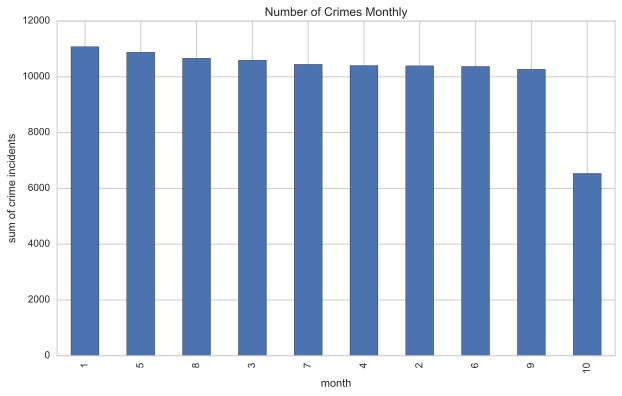

In [24]:
plt.figure(figsize=(10,6))
month_crime = crime2016_complete.groupby('month')['category'].count().sort_values(ascending=False)
month_crime_viz = mxtonth_crime.plot(kind='bar', title='Number of Crimes Monthly')
month_crime_viz.set_xlabel('month')
month_crime_viz.set_ylabel('sum of crime incidents')
month_crime_viz.set_axis_bgcolor('white')
plt.show()

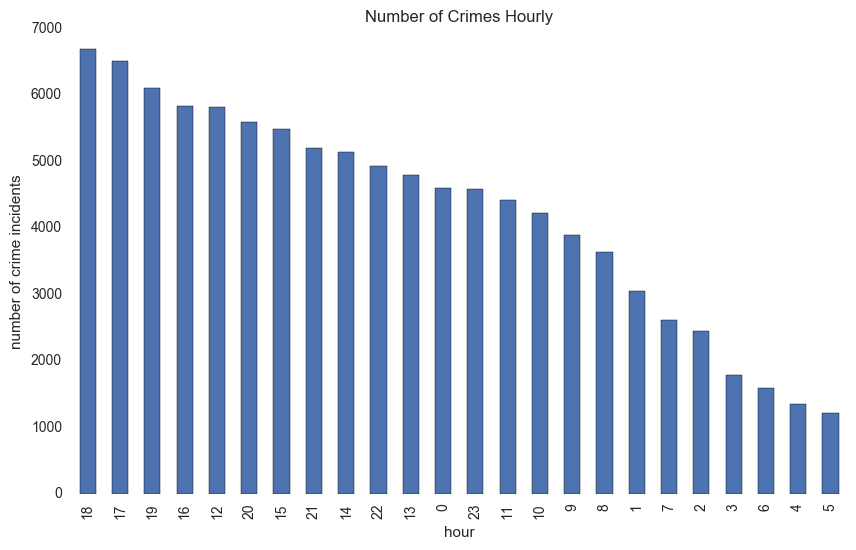

In [5]:
plt.figure(figsize=(10,6))
hour_crime = crime2016_complete.groupby('hour')['category'].count().sort_values(ascending=False)
#hour_crime = crime2016_complete.groupby('hour')['category'].count()
hour_crime_viz = hour_crime.plot(kind='bar', title='Number of Crimes Hourly')
hour_crime_viz.set_xlabel('hour')
hour_crime_viz.set_ylabel('number of crime incidents')
hour_crime_viz.set_axis_bgcolor('white')
plt.show()

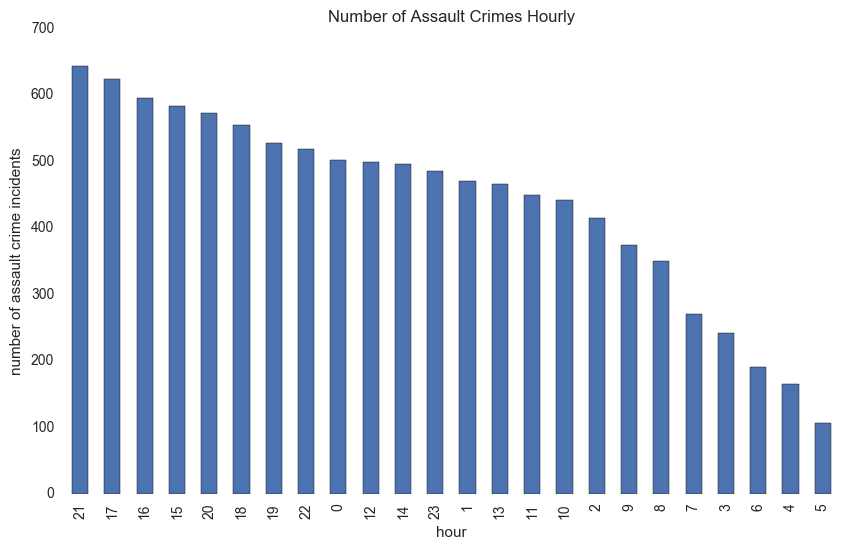

In [8]:
plt.figure(figsize=(10,6))
assault = crime2016_complete[crime2016_complete.category=='assault']
hour_assault = assault.groupby('hour')['category'].count().sort_values(ascending=False)
#hour_assault = assault.groupby('hour')['category'].count()
assault_viz = hour_assault.plot(kind='bar', title='Number of Assault Crimes Hourly')
assault_viz.set_xlabel('hour')
assault_viz.set_ylabel('number of assault crime incidents')
assault_viz.set_axis_bgcolor('white')
plt.show()

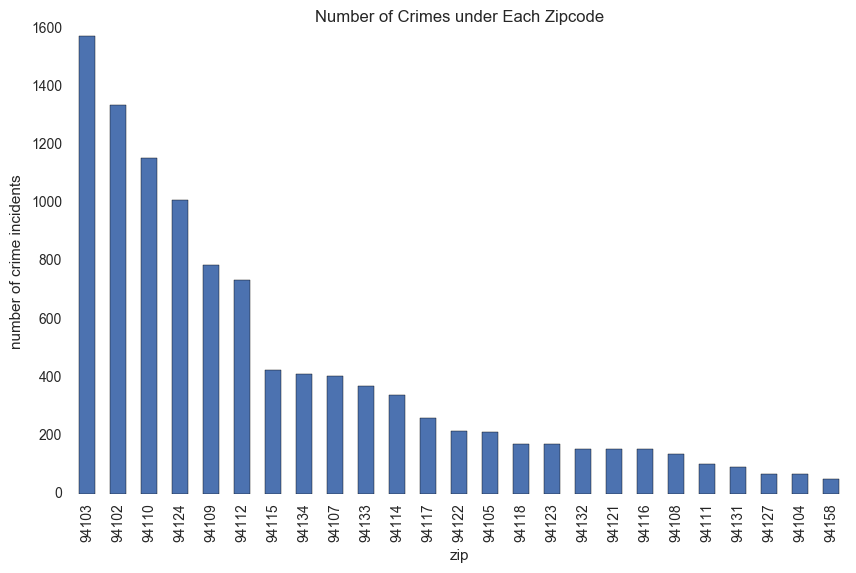

In [7]:
plt.figure(figsize=(10,6))
zip_crime = assault.groupby('zipcode')['category'].count().sort_values(ascending=False)
zip_crime_viz = zip_crime.plot(kind='bar', title='Number of Crimes under Each Zipcode')
zip_crime_viz.set_xlabel('zip')
zip_crime_viz.set_ylabel('number of crime incidents')
zip_crime_viz.set_axis_bgcolor('white')
plt.show()

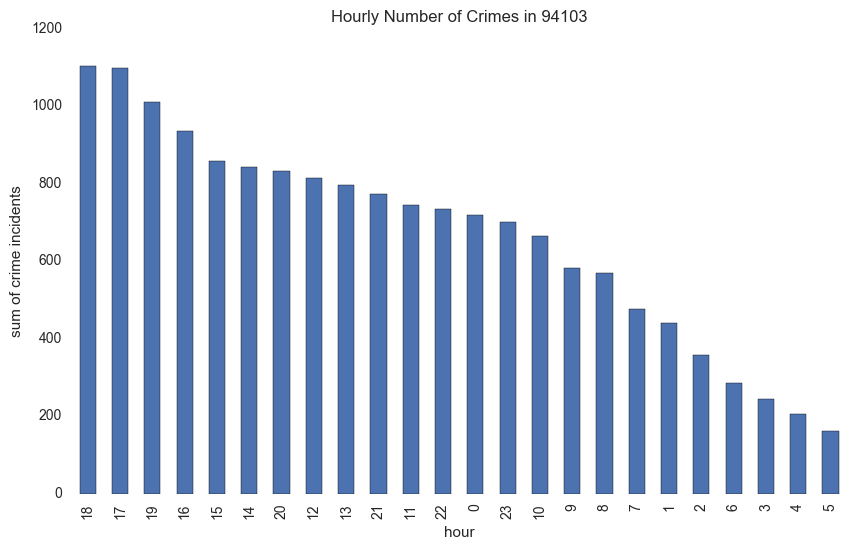

In [9]:
plt.figure(figsize=(10,6))
crime_94103 = crime2016_complete[crime2016_complete.zipcode == '94103']
crime_94103_hour = crime_94103.groupby('hour')['category'].count().sort_values(ascending=False)
crime_94103_hour_viz = crime_94103_hour.plot(kind='bar', title='Hourly Number of Crimes in 94103')
crime_94103_hour_viz.set_xlabel('hour')
crime_94103_hour_viz.set_ylabel('sum of crime incidents')
crime_94103_hour_viz.set_axis_bgcolor('white')
plt.show()

In [81]:
sf_demo_socio.head(1)

,zipcode,tol_pop_male,tol_pop_female,age10_14,age15_19,age20_24,age25_34,age35_44,age45_54,age55_59,...,age18_over_female,age65_over_male,age65_over_female,race_white,race_black,race_native,race_asian,race_hawaiian_pislander,race_others,race_his_lat
0,94102,15939,12074,361,1148,1672,6404,4418,4876,1857,...,10615,2015,2300,12032,3670,326,8652,122,1884,4779


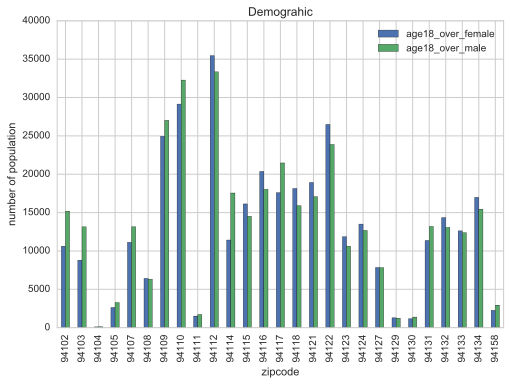

In [25]:
plt.figure(figsize=(25,25))
zip_demo = sf_demo_socio.groupby('zipcode')['age18_over_female','age18_over_male'].sum()
zip_demo_viz = zip_demo.plot(kind='bar', title='Demograhic')
zip_demo_viz.set_xlabel('zipcode')
zip_demo_viz.set_ylabel('number of population')
zip_demo_viz.set_axis_bgcolor('white')
plt.show()

## cleaning data

In [107]:
crime2016_complete['date'] = crime2016_complete['new_time'].apply(lambda x: datetime.datetime(x.year,x.month,x.day))
#drop na
crime2016_complete.dropna(inplace=True)
#only look at actual crime incidents
crime2016_complete = crime2016_complete[crime2016_complete['category'] != 'non-criminal']
#drop columns that are not features
crime2016_complete = crime2016_complete.drop(['incidntnum', 'descript', 'date', 'time', 'neighborhood', 'address_x', 'x', 'y', 'location',
              'address_y', 'year', 'resolution', 'new_resolution', 'pdid', 'race - one race', 'sex and age - under 5 years',
              'sex and age - total population','sex and age - 5 to 9 years', 'sex and age - 18 years and over',
              'sex and age - 21 years and over', 'sex and age - 62 years and over', 'sex and age - 65 years and over', 
              'sex and age - 18 years and over.1', 'sex and age - 65 years and over.1', 'race - two or more races',
              'race - race alone or in combination with one or more other races - total population - white',
              'race - race alone or in combination with one or more other races - total population - black or african american',
              'race - race alone or in combination with one or more other races - total population - american indian and alaska native',
              'race - race alone or in combination with one or more other races - total population - asian',
              'race - race alone or in combination with one or more other races - total population - native hawaiian and other pacific islander',
              'race - race alone or in combination with one or more other races - total population - some other race'], axis=1)

crime2016_complete = crime2016_complete.rename(columns={#'sex and age - total population': 'tol_pop',
                'sex and age - total population - male': 'tol_pop_male',
                'sex and age - total population - female': 'tol_pop_female',
                #'sex and age - under 5 years':'under_5',
                #'sex and age - 5 to 9 years': 'age5_9', 
                'sex and age - 10 to 14 years': 'age10_14',
                'sex and age - 15 to 19 years': 'age15_19', 
                'sex and age - 20 to 24 years': 'age20_24',
                'sex and age - 25 to 34 years': 'age25_34',
                'sex and age - 35 to 44 years': 'age35_44', 
                'sex and age - 45 to 54 years': 'age45_54',
                'sex and age - 55 to 59 years': 'age55_59',
                'sex and age - 60 to 64 years': 'age60_64', 
                'sex and age - 65 to 74 years': 'age65_74',
                'sex and age - 75 to 84 years': 'age75_84',
                'sex and age - 85 years and over': 'age85_over',
                'sex and age - median age (years)': 'median_age_in_years',
                #'sex and age - 18 years and over': 'age18_over',
                #'sex and age - 21 years and over': 'age21_over', 
                #'sex and age - 62 years and over': 'age62_over',
                #'sex and age - 65 years and over': 'age65_over', 
                'sex and age - 18 years and over - male': 'age18_over_male', 
                'sex and age - 18 years and over - female': 'age18_over_female',
                'sex and age - 65 years and over - male': 'age65_over_male',
                'sex and age - 65 years and over - female': 'age65_over_female', 
                #'race - one race': 'tol_race', 
                'race - one race - white': 'race_white',
                'race - one race - black or african american': 'race_black', 
                'race - one race - asian': 'race_asian',
                'race - one race - american indian and alaska native': 'race_native',
                'race - one race - native hawaiian and other pacific islander': 'race_hawaiian_pislander',
                'race - one race - some other race': 'race_others',
                'hispanic or latino and race - total population - hispanic or latino (of any race)': 'race_his_lat'})

ValueError: labels ['incidntnum' 'year' 'pdid' 'race - one race' 'sex and age - under 5 years'
 'sex and age - total population' 'sex and age - 5 to 9 years'
 'sex and age - 18 years and over' 'sex and age - 21 years and over'
 'sex and age - 62 years and over' 'sex and age - 65 years and over'
 'sex and age - 18 years and over.1' 'sex and age - 65 years and over.1'
 'race - two or more races'
 'race - race alone or in combination with one or more other races - total population - white'
 'race - race alone or in combination with one or more other races - total population - black or african american'
 'race - race alone or in combination with one or more other races - total population - american indian and alaska native'
 'race - race alone or in combination with one or more other races - total population - asian'
 'race - race alone or in combination with one or more other races - total population - native hawaiian and other pacific islander'
 'race - race alone or in combination with one or more other races - total population - some other race'] not contained in axis

In [ ]:
cat1 = {'bribery':1 , 'burglary': 1, 'bad checks': 1, 'embezzlement':1 , 'extortion': 1, 'forgery/counterfeiting':1,\
        'fraud':1 , 'robbery':1, 'stolen property':1, 'suspicious occ':1, 'warrants': 1, 'gambling':1}

cat2 = {'assault': 2, 'disorderly conduct':2, 'family offenses':2, 'pornography/obscene mat':2, 'prostitution':2,\
        'sex offenses, forcible': 2, 'sex offenses, non forcible': 2, 'kidnapping': 2, 'suicide': 2,\
        'missing person': 2,'other offenses':2}

cat3 = {'arson': 3, 'weapon laws': 3, 'driving under the influence': 3, 'drug/narcotic': 3, 'drunkenness': 3,\
        'liquor laws': 3,  'runaway': 3, 'secondary codes': 3, 'trea': 3, 'trespass': 3, 'loitering':3, 'vandalism': 3}

cat4 = {'larceny/theft': 4, 'vehicle theft': 4, 'recovered vehicle':4}

def crime_cat_mapping(cat):
    if cat in cat1.keys():
        return 'cat1'
    elif cat in cat2.keys():
        return 'cat2'
    elif cat in cat3.keys():
        return 'cat3'
    elif cat in cat4.keys():
        return 'cat4'
    else:
        return np.nan

In [108]:
crime2016_complete['category'] = crime2016_complete['category'].apply(crime_cat_mapping)

In [109]:
crime2016_complete = crime2016_complete.drop('new_time', axis=1)

In [111]:
crime = crime2016_complete.copy()

In [113]:
crime.head(1)

,category,descript,dayofweek,time,pddistrict,resolution,address_x,x,y,location,...,race_black,race_native,race_asian,race_hawaiian_pislander,race_others,race_his_lat,median_income,median_home_value,median_rent,date
0,cat2,battery,friday,08:00,northern,"arrest, booked",union st / gough st,-122.427271,37.798134,"(37.7981336020854, -122.427270640646)",...,321.0,26.0,2735.0,15.0,260.0,1593.0,112650.0,1000000.0,1838.0,2016-08-26


### Predicting hourly number of crimes in April, May, and June, using previous three months' data (January, February, and March)

In [114]:
crime_jan_mar = crime[(crime.month == 1) | (crime.month == 2) | (crime.month == 3)]
crime_jan_mar_zipcode = crime_jan_mar.groupby(['zipcode', 'hour'])['category'].count().reset_index()
crime_jan_mar_zipcode = crime_jan_mar_zipcode.rename(columns={'category': 'number_of_crime'})

# find out missing values (because no crime happen at specific hour) 
# and fill in the hour of time and number of crime with 0
missing_94158_94104 = pd.DataFrame([['94158', 4, 0], ['94104', 3, 0], ['94104', 4, 0]], 
                                   columns=['zipcode', 'hour', 'number_of_crime'])
crime_jan_mar_zipcode = crime_jan_mar_zipcode.append(missing_94158_94104)

crime_jan_mar_complete = crime_jan_mar_zipcode.merge(sf_demo_socio,how='left',on='zipcode')

In [115]:
zip_dummy = pd.get_dummies(crime_jan_mar_complete['zipcode'])
crime_jan_mar_dum = pd.concat([zip_dummy, crime_jan_mar_complete], axis=1)
crime_jan_mar_dum = crime_jan_mar_dum.drop('zipcode', axis=1)

features = [col for col in crime_jan_mar_dum.columns if col != 'number_of_crime']

X_train, y_train = crime_jan_mar_dum[features], crime_jan_mar_dum['number_of_crime']
print X_train.shape, y_train.shape

(600, 51) (600,)


In [116]:
crime_apr_jun = crime[(crime.month == 4) | (crime.month == 5) | (crime.month ==6)]
crime_apr_jun_zipcode = crime_apr_jun.groupby(['zipcode', 'hour'])['category'].count().reset_index()
crime_apr_jun_zipcode = crime_apr_jun_zipcode.rename(columns={'category': 'number_of_crime'})

# find out missing values (because no crime happen at specific hour) 
# and fill in the hour of time and number of crime with 0
missing_94104_94127_94158 = pd.DataFrame([['94104', 2, 0], ['94127', 5, 0], ['94158', 4, 0]], 
                                         columns=['zipcode', 'hour', 'number_of_crime'])

crime_apr_jun_zipcode = crime_apr_jun_zipcode.append(missing_94104_94127_94158)
crime_apr_jun_complete = crime_apr_jun_zipcode.merge(sf_demo_socio, how='left', on='zipcode')

In [117]:
zip_dummy = pd.get_dummies(crime_apr_jun_complete['zipcode'])
crime_apr_jun_dum = pd.concat([zip_dummy, crime_apr_jun_complete], axis=1)
crime_apr_jun_dum = crime_apr_jun_dum.drop('zipcode', axis=1)

X_test, y_test = crime_apr_jun_dum[features], crime_apr_jun_dum['number_of_crime']
print X_test.shape, y_test.shape

(600, 51) (600,)


## July to September

In [118]:
crime_jul_sep = crime[(crime.month == 7) | (crime.month == 8) | (crime.month == 9)]
crime_jul_sep_zipcode = crime_jul_sep.groupby(['zipcode', 'hour'])['category'].count().reset_index()
crime_jul_sep_zipcode = crime_jul_sep_zipcode.rename(columns={'category': 'number_of_crime'})

In [119]:
# 94116 3am
crime_jul_sep_zipcode[crime_jul_sep_zipcode.zipcode == '94116']
missing_94116 = pd.DataFrame([['94116', 3, 0]], columns=['zipcode', 'hour', 'number_of_crime'])
crime_jul_sep_zipcode = crime_jul_sep_zipcode.append(missing_94116)

In [120]:
crime_jul_sep_complete = crime_jul_sep_zipcode.merge(sf_demo_socio, how='left', on='zipcode')

In [121]:
zip_dummy = pd.get_dummies(crime_jul_sep_complete['zipcode'])
crime_jul_sep_dum = pd.concat([zip_dummy, crime_jul_sep_complete], axis=1)
crime_jul_sep_dum = crime_jul_sep_dum.drop('zipcode', axis=1)

In [122]:
X_jul_test, y_jul_test = crime_jul_sep_dum[features], crime_jul_sep_dum['number_of_crime']
print X_jul_test.shape, y_jul_test.shape

(600, 51) (600,)


## Modeling
### Linear Regression

In [123]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [124]:
lr.score(X_train, y_train)

0.79388886967336192

In [125]:
lr.score(X_test, y_test)

0.78041361846572377

In [126]:
mse_lr = mean_squared_error(y_test, y_pred)
mae_lr = mean_absolute_error(y_test, y_pred)

print mse_lr, mae_lr

653.43838115 16.9920175169


In [127]:
lr_coef = pd.DataFrame(lr.coef_, index=X_train.columns, columns=['coef'])
lr_coef = lr_coef['coef'].sort_values(ascending=False)

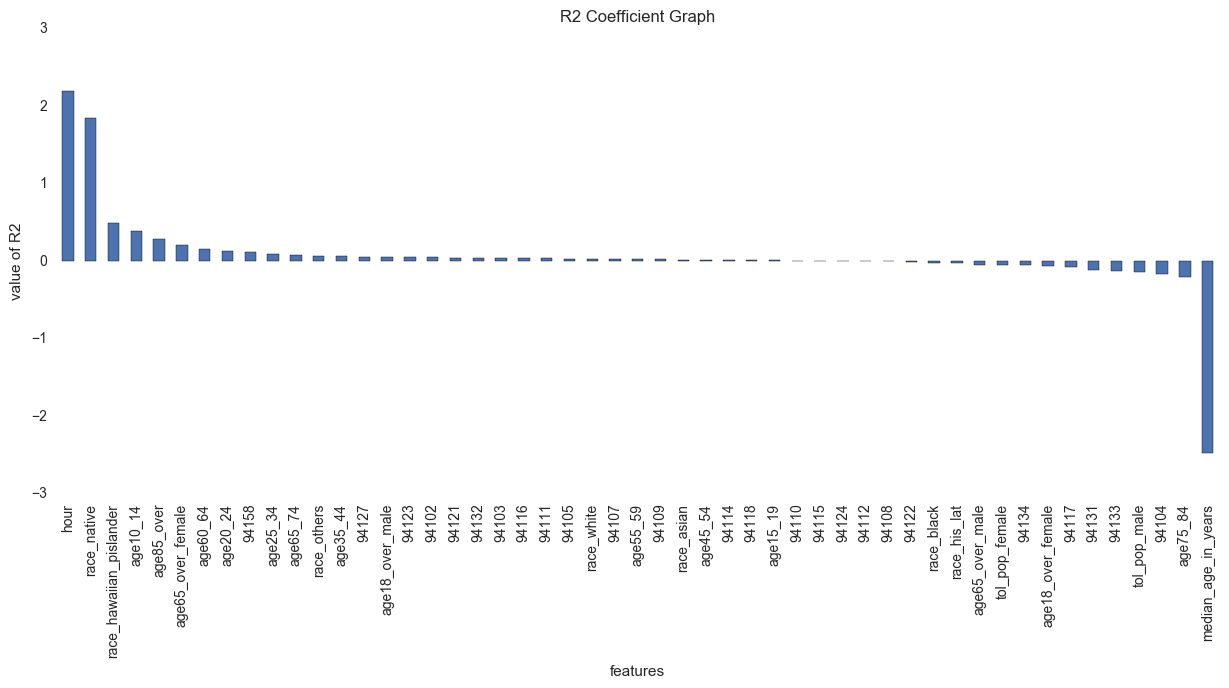

In [128]:
plt.figure(figsize=(15,6))
lr_coef_viz = lr_coef.plot(kind='bar', title='R2 Coefficient Graph')
lr_coef_viz.set_xlabel('features')
lr_coef_viz.set_ylabel('value of R2')
lr_coef_viz.set_axis_bgcolor('white')
plt.show()

In [130]:
lr_apr_jul = LinearRegression()

lr_apr_jul.fit(X_test, y_test)
y_jul_sep_pred = lr_apr_jul.predict(X_jul_test)

lr_apr_jul.score(X_jul_test, y_jul_test)

0.79348759205531394

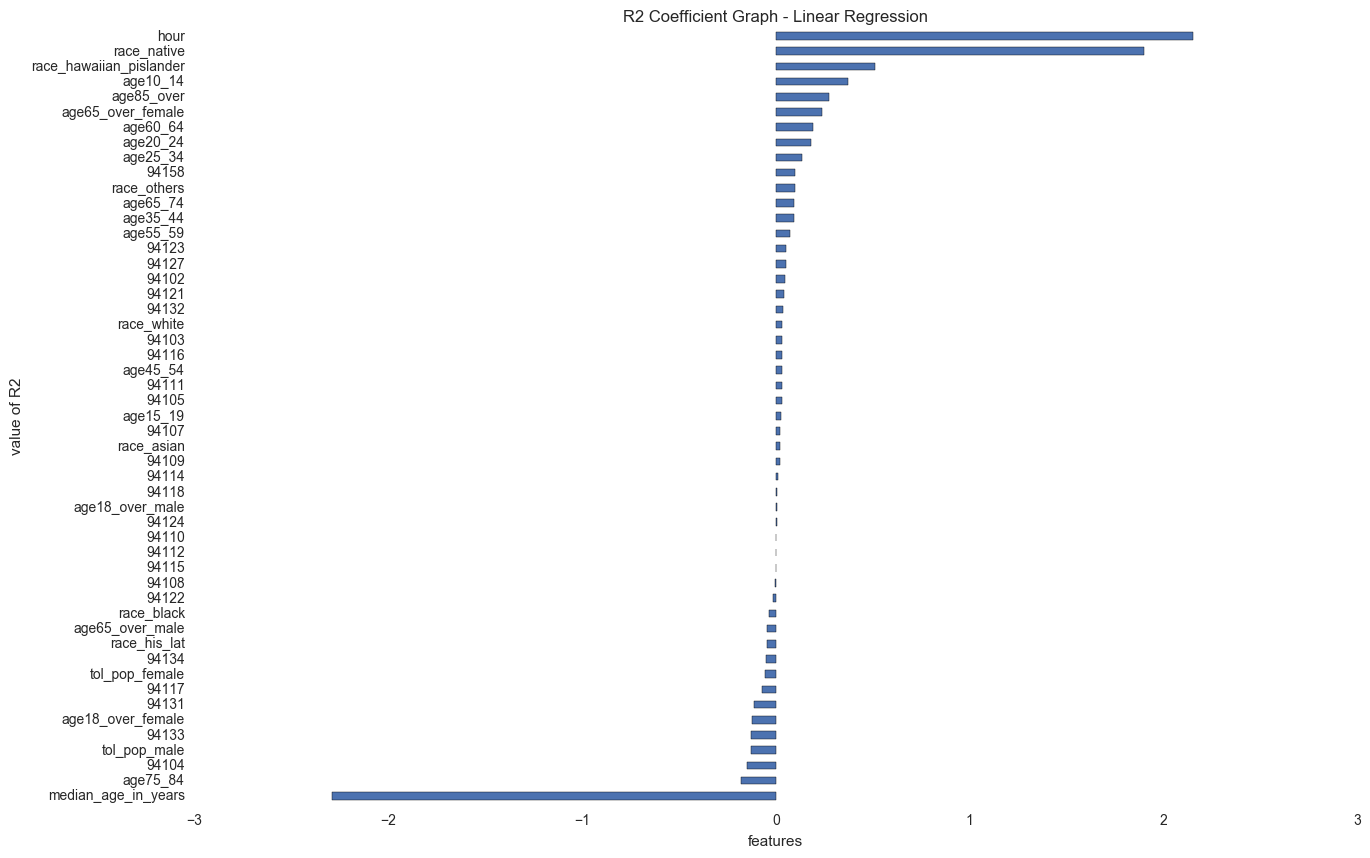

In [132]:
lr_coef_apr_jul = pd.DataFrame(lr_apr_jul.coef_, index=X_test.columns, columns=['coef'])
lr_coef_apr_jul = lr_coef_apr_jul['coef'].sort_values(ascending=True)
plt.figure(figsize=(15,10))
lr_coef_apr_jul_viz = lr_coef_apr_jul.plot(kind='barh', title='R2 Coefficient Graph - Linear Regression')
lr_coef_apr_jul_viz.set_xlabel('features')
lr_coef_apr_jul_viz.set_ylabel('value of R2')
lr_coef_apr_jul_viz.set_axis_bgcolor('white')
plt.show()

## Decision Tree Regressor

In [133]:
dtr = DecisionTreeRegressor()
dtr.fit(X_train, y_train)
y_dtr_pred = dtr.predict(X_test)
dtr.score(X_test, y_test)

0.92196303279558456

In [137]:
mse_dt = mean_squared_error(y_test, y_dtr_pred)
mae_dt = mean_absolute_error(y_test, y_dtr_pred)

print 'mean square error: ', mse_dt, '\n', 'mean absolute error: ', mae_dt

mean square error:  232.22 
mean absolute error:  10.57


In [138]:
dtr_feat = pd.DataFrame(dtr.feature_importances_, index=X_test.columns, columns=['feat_imp'])
dtr_feat = dtr_feat['feat_imp'].sort_values(ascending=True)

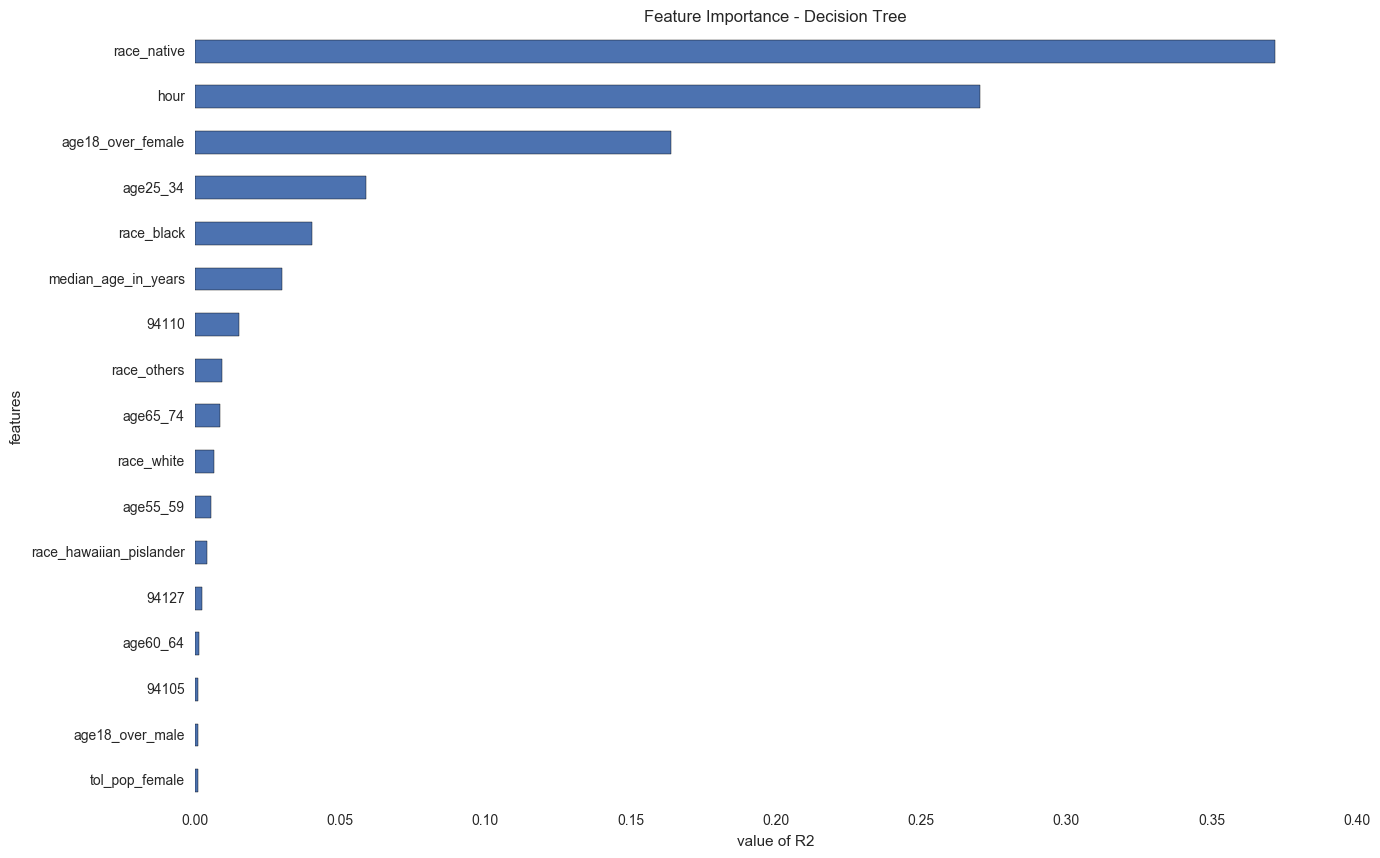

In [140]:
plt.figure(figsize=(15,10))
dtr_feat_viz = dtr_feat[34:].plot(kind='barh', title='Feature Importance - Decision Tree')
dtr_feat_viz.set_ylabel('features')
dtr_feat_viz.set_xlabel('value of R2')
dtr_feat_viz.set_axis_bgcolor('white')
plt.show()

## random forrest

In [142]:
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)
y_pred = rfr.predict(X_test)
rfr.score(X_test, y_test)

0.93424255273027002

In [143]:
mse_rfr = mean_squared_error(y_test, y_pred)
mae_rfr = mean_absolute_error(y_test, y_pred)
print 'mean square error: ', mse_rfr, '\n', 'mean absolute error: ', mae_rfr

mean square error:  195.678983333 
mean absolute error:  9.4955


In [144]:
rfr_co = pd.DataFrame(rfr.feature_importances_)
rfr_co.index = X_train.columns
rfr_co = rfr_co.rename(columns={0:'feature_importances'})
rfr_co = rfr_co['feature_importances'].sort_values(ascending=True)

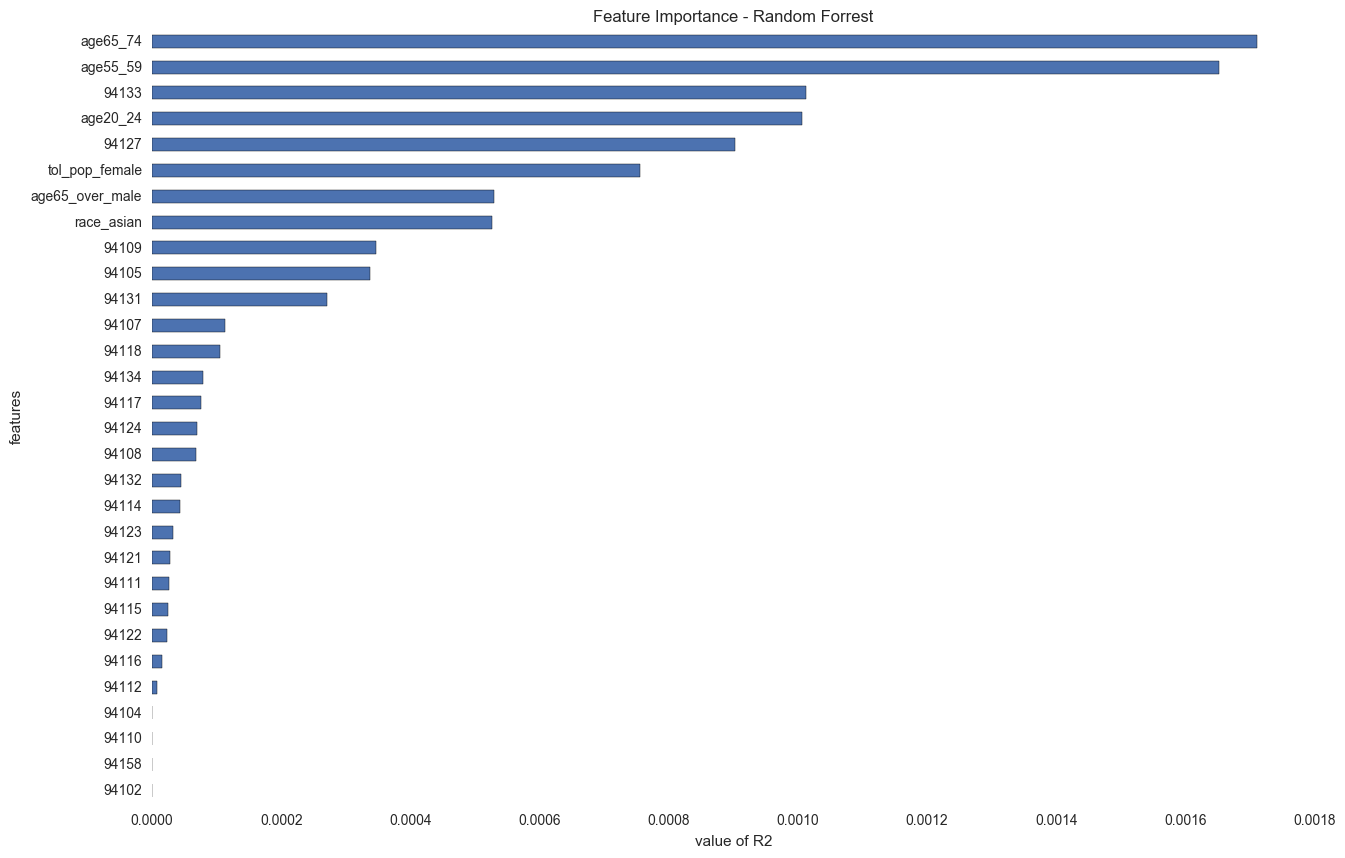

In [145]:
plt.figure(figsize=(15,10))
rfr_co_viz = rfr_co[:30].plot(kind='barh', title='Feature Importance - Random Forrest')
rfr_co_viz.set_ylabel('features')
rfr_co_viz.set_xlabel('value of R2')
rfr_co_viz.set_axis_bgcolor('white')
plt.show()

In [146]:
## use April-June to predict July-September

In [147]:
rfr1 = RandomForestRegressor()
rfr1.fit(X_test, y_test)
y_jul_pred = rfr1.predict(X_jul_test)
rfr1.score(X_jul_test, y_jul_test)

0.93704116552965067

In [148]:
mse_rfr1 = mean_squared_error(y_jul_test, y_jul_pred)
mae_rfr1 = mean_absolute_error(y_jul_test, y_jul_pred)
print 'mean square error: ', mse_rfr1, '\n', 'mean absolute error: ', mae_rfr1

mean square error:  177.962916667 
mean absolute error:  9.07983333333


## use first 12 hours to predict next 12 hours

In [149]:
first12 = (crime_jan_mar_complete.hour == 1) | (crime_jan_mar_complete.hour == 2) | (crime_jan_mar_complete.hour == 3) |\
          (crime_jan_mar_complete.hour == 4) | (crime_jan_mar_complete.hour == 5) | (crime_jan_mar_complete.hour == 6) |\
          (crime_jan_mar_complete.hour == 7) | (crime_jan_mar_complete.hour == 8) | (crime_jan_mar_complete.hour == 9) |\
          (crime_jan_mar_complete.hour == 10) | (crime_jan_mar_complete.hour == 11) | (crime_jan_mar_complete.hour == 12)

second12 = (crime_jan_mar_complete.hour == 13) | (crime_jan_mar_complete.hour == 14) | (crime_jan_mar_complete.hour == 15) |\
          (crime_jan_mar_complete.hour == 16) | (crime_jan_mar_complete.hour == 17) | (crime_jan_mar_complete.hour == 18) |\
          (crime_jan_mar_complete.hour == 19) | (crime_jan_mar_complete.hour == 20) | (crime_jan_mar_complete.hour == 21) |\
          (crime_jan_mar_complete.hour == 22) | (crime_jan_mar_complete.hour == 23) | (crime_jan_mar_complete.hour == 0)
jan_mar_frist12 = crime_jan_mar_complete[first12]
jan_mar_second12 = crime_jan_mar_complete[second12]

In [150]:
def dummies(df):
    zip_dummy = pd.get_dummies(df['zipcode'])
    df_dum = pd.concat([zip_dummy, df], axis=1)
    df_dum = df_dum.drop('zipcode', axis=1)
    return df_dum

In [151]:
def get_features(df):
    features = [col for col in df.columns if col != 'number_of_crime']
    return features

jan_mar_frist12_dum = dummies(jan_mar_frist12)
jan_mar_second12_dum = dummies(jan_mar_second12)

features = get_features(jan_mar_frist12_dum)

X_jan_train = jan_mar_frist12_dum[features]
y_jan_train = jan_mar_frist12_dum['number_of_crime']
X_jan_test = jan_mar_second12_dum[features]
y_jan_test = jan_mar_second12_dum['number_of_crime']

In [152]:
rfr_12 = RandomForestRegressor()
rfr_12.fit(X_jan_train, y_jan_train)
y_12_pred = rfr_12.predict(X_jan_test)
rfr_12.score(X_jan_test, y_jan_test)

0.8650756998794783

In [153]:
print 'mean squared error: ', mean_squared_error(y_jan_test, y_12_pred),'\n',\
      'mean absolute error: ', mean_absolute_error(y_jan_test, y_12_pred)

mean squared error:  452.154566667 
mean absolute error:  15.641


In [154]:
## april to june
first12 = (crime_apr_jun_complete.hour == 1) | (crime_apr_jun_complete.hour == 2) | (crime_apr_jun_complete.hour == 3) |\
          (crime_apr_jun_complete.hour == 4) | (crime_apr_jun_complete.hour == 5) | (crime_apr_jun_complete.hour == 6) |\
          (crime_apr_jun_complete.hour == 7) | (crime_apr_jun_complete.hour == 8) | (crime_apr_jun_complete.hour == 9) |\
          (crime_apr_jun_complete.hour == 10) | (crime_apr_jun_complete.hour == 11) | (crime_apr_jun_complete.hour == 12)

second12 = (crime_apr_jun_complete.hour == 13) | (crime_apr_jun_complete.hour == 14) | (crime_apr_jun_complete.hour == 15) |\
          (crime_apr_jun_complete.hour == 16) | (crime_apr_jun_complete.hour == 17) | (crime_apr_jun_complete.hour == 18) |\
          (crime_apr_jun_complete.hour == 19) | (crime_apr_jun_complete.hour == 20) | (crime_apr_jun_complete.hour == 21) |\
          (crime_apr_jun_complete.hour == 22) | (crime_apr_jun_complete.hour == 23) | (crime_apr_jun_complete.hour == 0)
apr_jun_frist12 = crime_apr_jun_complete[first12]
apr_jun_second12 = crime_apr_jun_complete[second12]

In [155]:
apr_jun_frist12_dum = dummies(apr_jun_frist12)
apr_jun_second12_dum = dummies(apr_jun_second12)

features = get_features(apr_jun_frist12_dum)

X_apr_train = apr_jun_frist12_dum[features]
y_apr_train = apr_jun_frist12_dum['number_of_crime']
X_apr_test = apr_jun_second12_dum[features]
y_apr_test = apr_jun_second12_dum['number_of_crime']

In [156]:
rfr_apr = RandomForestRegressor()
rfr_apr.fit(X_apr_train, y_apr_train)
y_apr_pred = rfr_apr.predict(X_apr_test)

In [157]:
rfr_apr.score(X_apr_test, y_apr_test)

0.86284597537639829

## load or save data

In [8]:
with open('../final_dataset/crime2016_origin_modified_col.pkl') as handle:
    crime2016_complete = pickle.load(handle)